In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import RegularGridInterpolator
from PIL import Image

sns.set_theme(palette=sns.color_palette("twilight_shifted"))

# Pinhole Camera
## Exercise 2.1

#### Resolution in pixels:
We have $\delta_x = 400$ and $\delta_y = 400$. We know, that both $\delta$ are signifying the distance from the middle of the image to the border of the image. The resolution is then $2\delta_x \times 2\delta_y = 800 \times 800$

In [3]:
def box3d(n: int) -> np.array:
    l = np.linspace(-.5, .5, n)
    ones = np.zeros(n)

    box = np.array([l, ones, ones])
    box = np.append(box, [l, ones-.5, ones-.5], axis=1)
    box = np.append(box, [l, ones-.5, ones+.5], axis=1)
    box = np.append(box, [l, ones+.5, ones+.5], axis=1)
    box = np.append(box, [l, ones+.5, ones-.5], axis=1)

    box = np.append(box, [ones, l, ones], axis=1)
    box = np.append(box, [ones-.5, l, ones-.5], axis=1)
    box = np.append(box, [ones-.5, l, ones+.5], axis=1)
    box = np.append(box, [ones+.5, l, ones+.5], axis=1)
    box = np.append(box, [ones+.5, l, ones-.5], axis=1)

    box = np.append(box, [ones, ones, l], axis=1)
    box = np.append(box, [ones-.5, ones-.5, l], axis=1)
    box = np.append(box, [ones-.5, ones+.5, l], axis=1)
    box = np.append(box, [ones+.5, ones+.5, l], axis=1)
    box = np.append(box, [ones+.5, ones-.5, l], axis=1)

    return box

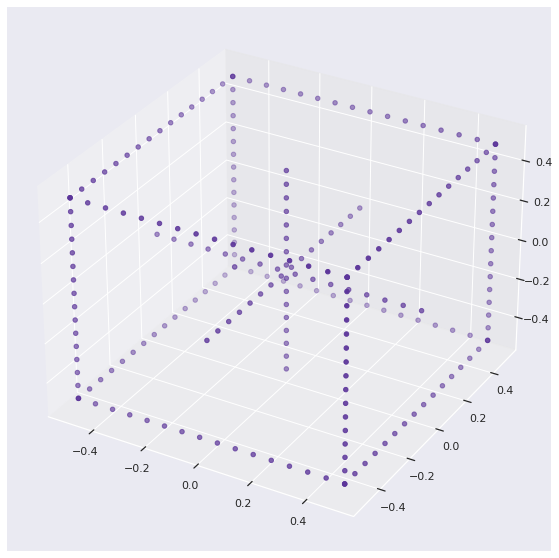

In [4]:
box = box3d(16)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(box[0], box[1], box[2])
plt.show()

P = array([[600. ,   0. , 400. , 600. ],
       [  0. , 600. , 400. , 720. ],
       [  0. ,   0. ,   1. ,   1.5]])


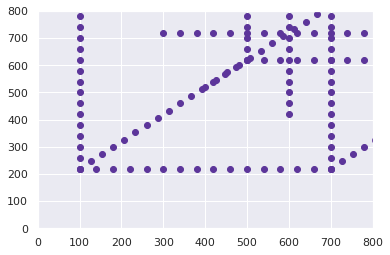

P = array([[600. ,   0. , 400. , 600. ],
       [  0. , 600. , 400. , 720. ],
       [  0. ,   0. ,   1. ,   1.5]])
Where does point P1 project to?
[100. 220.]


In [5]:
def projectpoints(K: np.array, R: np.array, t: np.array, Q: np.array):
    t = t.reshape(len(t), 1)
    Rt = np.append(R, t, axis=1)
    P = K @ Rt
        
    print(f"{P = }")
    Qh = np.append(Q, np.ones((1, Q.shape[1])), axis=0)
    return P @ Qh

f = 600
alpha = 1
beta = 0
delta_x = delta_y = 400

K = np.array([
    [f, beta * f, delta_x],
    [0, alpha * f, delta_y],
    [0, 0, 1]
])

theta = 0
R = np.array([
    [np.cos(np.deg2rad(theta)), 0, np.sin(np.deg2rad(theta))],
    [0, 1, 0],
    [-np.sin(np.deg2rad(theta)), 0, np.cos(np.deg2rad(theta))]
])

t = np.array([0, .2, 1.5])

projected = projectpoints(K, R, t, box)
plt.scatter(projected[0], projected[1])
plt.xlim(0, 800)
plt.ylim(0, 800)
plt.show()


P1 = np.array([-.5, -.5, -.5])
projected_P1 = projectpoints(K, R, t, np.array([P1]).T)
print("Where does point P1 project to?")
print(projected_P1[:-1,0])

## Exercise 2.2
Implement dist in projectpoints function

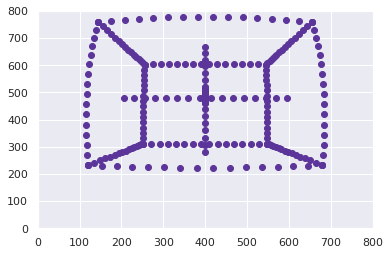

Where does point P1 project to?
[120.4  232.24]


In [6]:
def projectpointsdist(K: np.array, R: np.array, t: np.array, dist: np.array, Q: np.array):
    t = t.reshape(len(t), 1)
    Rt = np.append(R, t, axis=1)
    homo_Q = np.append(Q, np.ones((1, Q.shape[1])), axis=0)
    
    RtQ = Rt @ homo_Q
    RtQ_inhomo = RtQ[:-1]/RtQ[-1]

    distances = np.linalg.norm(RtQ_inhomo, axis=0) ** 2
    coffs_dists = (distances * dist.reshape(dist.size, 1))
    sums = np.sum(coffs_dists, axis=0)
    
    dist_p = RtQ_inhomo * (1 + sums)
    
    RtQ_homo = np.append(dist_p, np.ones((1, RtQ_inhomo.shape[1])), axis=0)
    
    return K @ RtQ_homo

f = 600
alpha = 1
beta = 0
delta_x = delta_y = 400

K = np.array([
    [f, beta * f, delta_x],
    [0, alpha * f, delta_y],
    [0, 0, 1]
])

theta = 0
R = np.identity(3)
t = np.array([0, .2, 1.5])

dist = np.array([-.2])
projected = projectpointsdist(K, R, t, dist, box)
plt.scatter(projected[0], projected[1])
plt.xlim(0, 800)
plt.ylim(0, 800)
plt.show()


P1 = np.array([-.5, -.5, -.5])
projected_P1 = projectpointsdist(K, R, t, dist, np.array([P1]).T)
print("Where does point P1 project to?")
print(projected_P1[:-1,0])

## Exercise 2.4 - Undistorting an image
Image is undistorted by distorting it with regards to the coefficients. As we are looking at an already projected geometry, aka the image is already taken, we cannot just do as previous and project 3d points to a 2d plane. Instead the coordinates are first converted to the inhomogenous camera coordinates using the inverse of the camera matrix, and then the distortion is achieved using the coeffs.

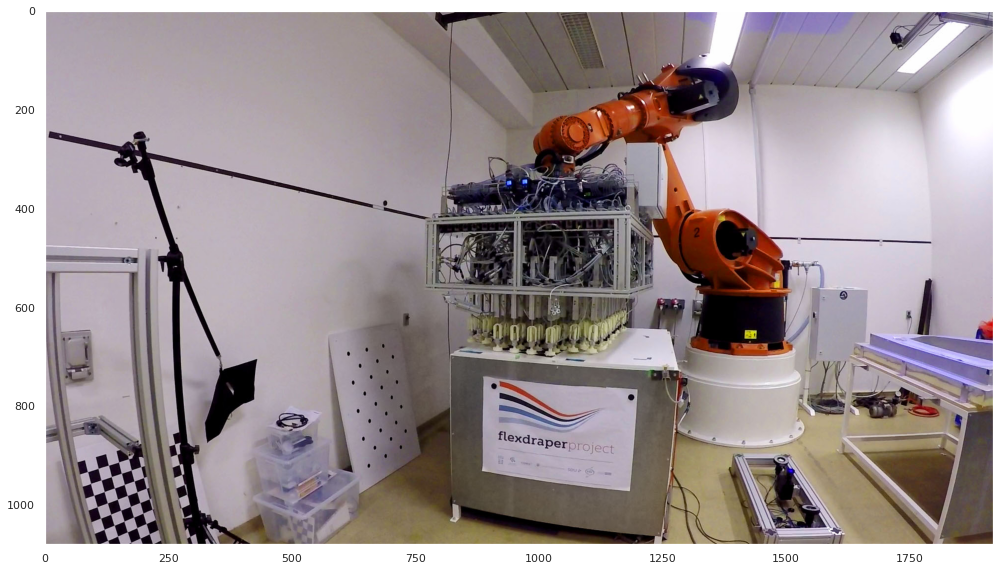

In [7]:
img = Image.open("gopro_robot.jpg")
arr = np.asarray(img)
arr = arr.transpose((1, 0, 2))

plt.figure(figsize=(17, 10))
plt.grid(False)
plt.imshow(arr.transpose((1, 0, 2)))
plt.show()

In [8]:
def distortImage(pixel_values: np.array, K: np.array, dist_coffs: np.array):
    img_coords = np.array(np.meshgrid(range(1920), range(1080), [1])).T.reshape(-1, 3).T
    inv_K = np.linalg.inv(K)

    homo_inv_camera_coords = inv_K @ img_coords
    inhomo_inv_camera_coords = homo_inv_camera_coords[:-1]/homo_inv_camera_coords[-1]

    # Takes the power in increasing order for each coefficient of the distances
    distances = np.linalg.norm(inhomo_inv_camera_coords, axis=0).reshape(-1, 1)
    # Power to the distances
    powers = np.arange(2, len(dist_coffs) * 2 + 1, step=2).reshape(-1, 1)
    # Distances to the increasing power according to formular
    power_dists = (distances ** powers.T)
    # Coefficients times the distances to the powers
    coff_dists = dist_coffs * power_dists
    # Sums of the distances
    sums = np.sum(coff_dists, axis=1)
    # New distorted projects
    dist_p = inhomo_inv_camera_coords * (1 + sums)
    # New homogenous coordinates
    homo = np.append(dist_p, np.ones((1, inhomo_inv_camera_coords.shape[1])), axis=0)
    # Projecting with camera matrix
    projected = K @ homo
    # Converting to inhomogenous coordinates
    inhomo_projected = projected[:-1]/projected[-1]
    # Creating pixel coordinates
    x, y = np.arange(0, 1920), np.arange(0, 1080)
    # Creating interpolator
    interpolator = RegularGridInterpolator((x, y), pixel_values)
    # Interpolating pixels
    pixels = interpolator(inhomo_projected.T).reshape((1920, 1080, 3)).transpose((1,0,2))
    # Normalizing pixels
    normalized = pixels/np.amax(pixels, axis=tuple(range(2)))
    return normalized


K = np.array([
    [875, 0, 960],
    [0, 875, 540],
    [0, 0, 1]
])

k3 = -0.245031
k5 = 0.071524
k7 = -0.00994978

coffs = np.array([k3, k5, k7])

pixels = distortImage(arr, K, coffs)

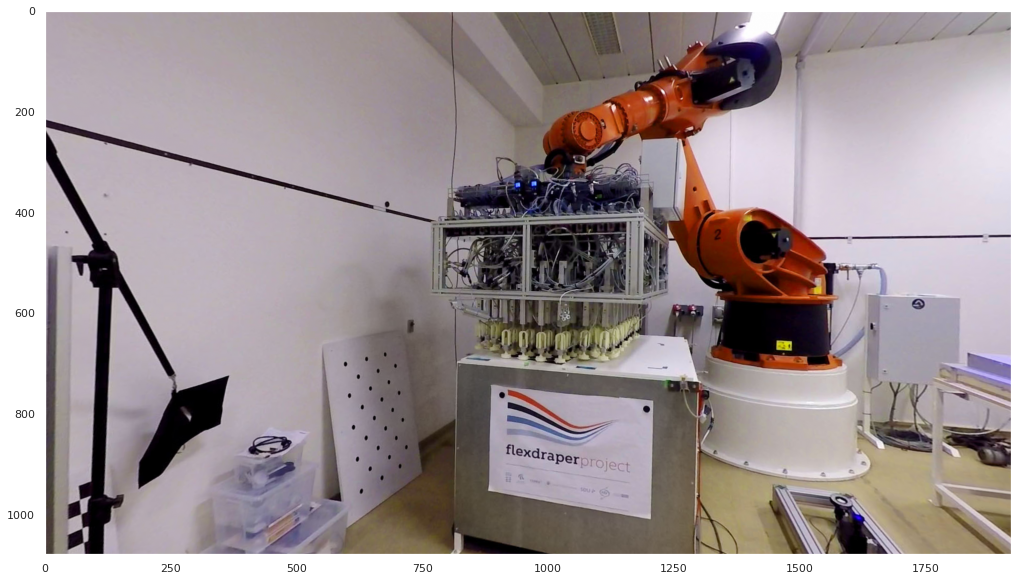

In [9]:
plt.figure(figsize=(17.7, 10))
plt.grid(False)
plt.imshow(pixels)
plt.show()

## Homographies

### Exercise 2.5

In [82]:
H = np.array([[-2, 0, 1], [1, -2, 0], [0, 0, 3]])

p = np.array([
    [1, 0, 2, 2],
    [1, 3, 3, 4]
    ])
[p1, p2, p3, p4] = p.T

homo_points = np.append(p, np.ones((1, 4)), axis=0)
q = H @ homo_points
q = q[:-1, :]/q[-1, :]
q, p

(array([[-0.33333333,  0.33333333, -1.        , -1.        ],
        [-0.33333333, -2.        , -1.33333333, -2.        ]]),
 array([[1, 0, 2, 2],
        [1, 3, 3, 4]]))

### Exercise 2.6

In [15]:
def hest(q1: np.array, q2: np.array) -> np.array:
    makeB = lambda p, q: np.array([
        [-p[0], -p[1], -1, 0, 0, 0, (p[0] * q[0]), (p[1] * q[0]), q[0]],
        [0, 0, 0, -p[0], -p[1], -1, (p[0] * q[1]), (p[1] * q[1]), q[1]]
    ])
    B = np.vstack([makeB(p, q) for p,q in zip(q1.T, q2.T)])
    # Creating the A matrix
    A = B.T @ B
    # Doing svd
    _, _, vh = np.linalg.svd(A)
    np.set_printoptions(suppress=True)
    # Taking the last row of the vh, as those are the eigenvectors with smallest eigenvalues
    H = vh[-1].reshape((3, 3))
    return H

H = np.array([[-2, 0, 1], [1, -2, 0], [0, 0, 3]])
test_H = hest(p, q)
test_H

array([[ 0.45883147, -0.        , -0.22941573],
       [-0.22941573,  0.45883147,  0.        ],
       [ 0.        , -0.        , -0.6882472 ]])

In [107]:

def hest_cron(t: np.array, f: np.array) -> np.array:
    # Creating matrix from (f) point to (t)
    def makeB(p: np.array, q: np.array) -> np.array:
        # q homogenous
        qh = np.append(q, 1)
        m = np.array([
            [0, -1, p[1]],
            [1, 0, -p[0]],
            [-p[1], p[0], 0]
        ])
        return np.kron(qh, m)
    
    B = np.vstack([makeB(p, q) for p, q in zip(t.T, f.T)])
    A = B.T @ B
    
    _, _, vh = np.linalg.svd(A)
    H = vh[-1].reshape((3, 3)).T
    return H
test_H = hest_cron(p, q )
print(f"{p[:, 0] = }, {q[:, 0] = }")
a = test_H @ np.append(p[:,0], 1)
a[:-1]/a[-1]

SyntaxError: invalid syntax (991923833.py, line 1)

In [44]:
a = np.array([[2, 3, 4]]).T
b = np.ones((2, 2))

np.kron(a, b)


array([[2., 2.],
       [2., 2.],
       [3., 3.],
       [3., 3.],
       [4., 4.],
       [4., 4.]])

## Exercise 2.7

In [12]:
def normalize2d(p: np.array):
    return (p - p.mean()) / (p.std())
def normalizeAll2d(p: np.array, q: np.array):
    mean = np.array([p, q]).mean()
    std = np.array([p, q]).std()
    norm_p = (p - mean)/(std)
    norm_q = (q - mean)/(std)
    return norm_p, norm_q

## Exercise 2.8

In [13]:
def hest(q1: np.array, q2: np.array) -> np.array:
    norm_p, norm_q = normalizeAll2d(q1, q2)
    makeB = lambda p, q: np.array([
        [-p[0], -p[1], -1, 0, 0, 0, (p[0] * q[0]), (p[1] * q[0]), q[0]],
        [0, 0, 0, -p[0], -p[1], -1, (p[0] * q[1]), (p[1] * q[1]), q[1]]
    ])
    B = np.vstack([makeB(p, q) for p, q in zip(norm_p.T, norm_q.T)])
    # Creating the A matrix
    A = B.T @ B
    # Doing svd
    _, _, vh = np.linalg.svd(A)
    # Taking the last row of the vh, as those are the eigenvectors with smallest eigenvalues
    H = vh[-1].reshape((3, 3))
    return H

test_H = hest(p, q) * 4.5
test_H

array([[-2.00561931,  0.        , -0.89430448],
       [ 1.00280965, -2.00561931, -1.16143439],
       [ 0.        , -0.        ,  3.00842896]])

## Exercise 2.9

In [14]:
N = 100
points = np.random.randn(2, N)
homo_points = np.vstack((points, np.ones(N)))

homo_qoints = H @ homo_points
qoints = homo_qoints[:-1]/homo_qoints[-1]

H = hest(points, qoints)
H

array([[ 0.46361753,  0.        , -0.15201856],
       [-0.23180876,  0.46361753,  0.0982594 ],
       [-0.        ,  0.        , -0.69542629]])